# Computer vision operation

> Different computer vision operations will be implemented here

In [ ]:
#| default_exp cv_ops

In [ ]:
#| export
import pandas as pd
from pathlib import Path
import numpy as np
from tqdm import tqdm
from fastcore.all import *
import matplotlib as mpl
import matplotlib.pyplot as plt
from fastcore.all import *
import shutil
import cv2
from typing import Union, List, Tuple, Dict
import pandas as pd
from skimage import io, morphology, measure
from skimage.morphology import disk
from skimage.filters import threshold_multiotsu
from scipy.ndimage import (label, sum, binary_fill_holes)
import os
from tqdm.auto import tqdm
import argparse

from datasets import load_dataset

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| hide
data_path=Path(r'/home/hasan/Schreibtisch/projects/data/microscopy/patch_train_images')
data_path.ls()

In [ ]:
#| hide
from cv_tools.core import *
import matplotlib.pyplot as plt

In [ ]:
#| export
def get_whole_dataset(
    split:str='train',
    name:str='hasangoni/Electron_microscopy_dataset',
    ):
    'Get the whole dataset'
    dataset = load_dataset(name, split=split)
    return dataset

In [ ]:
#| export
def get_single_sample(
    split:str='train',
    INDEX=0,
    name:str='hasangoni/Electron_microscopy_dataset',
    type:str='numpy' #  numpy, torch, pil
    ):
    'Get a single sample from the dataset'
    wh_dataset = get_whole_dataset(split=split, name=name)
    sample = wh_dataset = wh_dataset[INDEX]
    if type == 'numpy':
        image, label = np.array(sample['image']), np.array(sample['label'])
    elif type == 'torch':
        image, label = torch.tensor(sample['image']), torch.tensor(sample['label'])
    elif type == 'pil':
        image, label = sample['image'],sample['label']
    else:
        raise ValueError(f"Invalid type: {type}")
    return image, label



In [ ]:
img, msk = get_single_sample(INDEX=0, type='numpy')

In [ ]:
#| export
def multi_otsu(img:np.array, classes:int=3)->np.array:
    """Multi-Otsu thresholding-> returns image of type np.uint8"""
    thresholds = threshold_multiotsu(img, classes)
    regions = np.digitize(img, bins=thresholds)
    # Scale the regions to span full 8-bit range (0-255) by multiplying by 255/(num_classes-1)
    # E.g. for 3 classes, maps [0,1,2] to [0,127,255]
    regions = regions*(255//(classes-1))
    return regions.astype(np.uint8)

In [ ]:
#| export
def remove_small_objects(
        binary_mask:np.ndarray,  # np.ndarry
        size_threshold:Union[float, int] # 
        ):
    'From a binary mask remove small objects'
    labeled_mask, num_labels = label(binary_mask)
    sizes = sum(binary_mask, labeled_mask, range(num_labels + 1))
    mask_sizes = sizes[labeled_mask]
    binary_mask = mask_sizes > size_threshold
    return binary_mask

In [ ]:
#| export
def fill_holes_in_objects(binary_mask):
    'Fill holes inside binary mask'
    filled_mask = binary_fill_holes(binary_mask)
    return filled_mask

In [ ]:
#| export
def convert_to_rotated_rectangles(binary_mask):
    'Convert binary mask arbitary from to  rotated rectange '
    contours, _ = cv2.findContours(binary_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    new_mask = np.zeros_like(binary_mask, dtype=np.uint8)
    for contour in contours:
        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)
        box = np.intp(box)
        cv2.drawContours(new_mask, [box], 0, (1), -1)
    return new_mask

# Background removal

In [ ]:
#| export
def rolling_ball_substraction(
    image:np.ndarray,
    radius:int=50, # normally 50-100, but depends on the image size and the background size
    ):
    'Rolling ball substraction'

    if len(image.shape) == 3:
        print('Image is RGB, converting to grayscale')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image.astype(np.float32)

    # Create a substracting element (ball)
    selem = disk(radius)

    # Opening
    # Opening removes small bright spots and smooths object boundaries
    # It's erosion followed by dilation - shrinks then expands objects
    background = cv2.morphologyEx(image, cv2.MORPH_OPEN, selem)

    # Subtract the background from the image
    result = cv2.subtract(image, background.astype(np.float32))

    # Normalize to 0-255
    result = cv2.normalize(result, None, 0, 255, cv2.NORM_MINMAX)
    # Again convert to uint8
    result = result.astype(np.uint8)

    return result







In [ ]:
#| hide
#| eval: false
b_img = rolling_ball_substraction(image=img, radius=50)
b_img_60 = rolling_ball_substraction(image=img, radius=60)
b_img_70 = rolling_ball_substraction(image=img, radius=70)
b_img_90 = rolling_ball_substraction(image=img, radius=90)
b_img_100 = rolling_ball_substraction(image=img, radius=100)



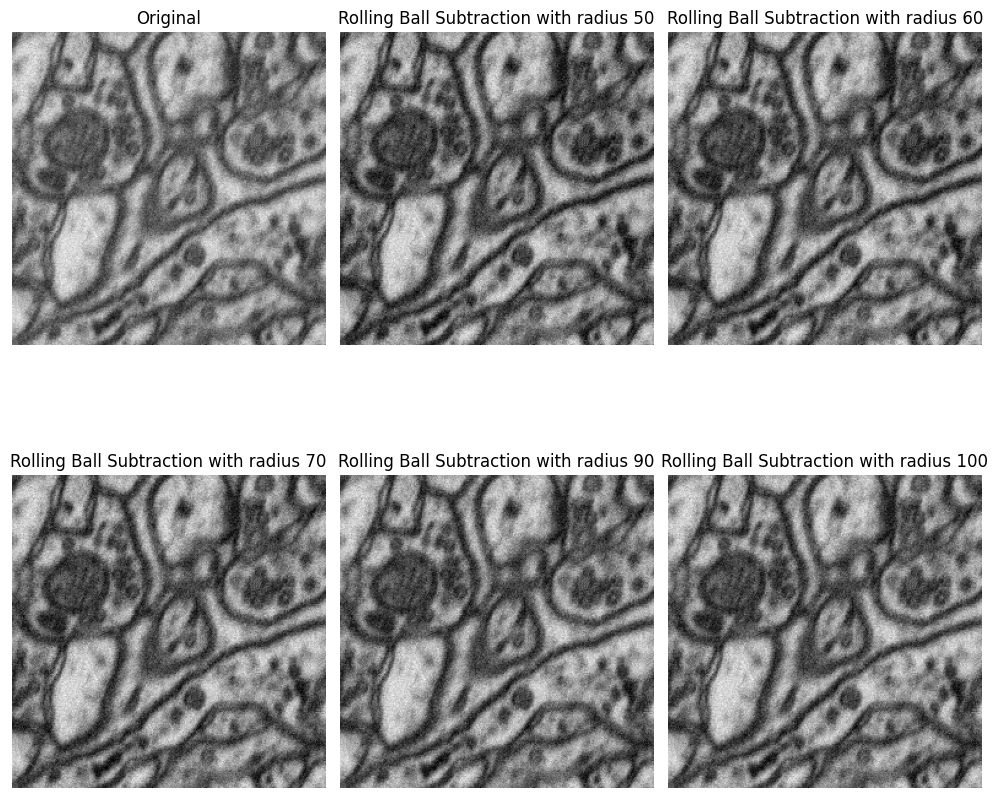

In [ ]:
#| eval: false
show_images_(
    images=[img, b_img, b_img_60, b_img_70, b_img_90, b_img_100], 
    titles=[
        'Original', 
        'Rolling Ball Subtraction with radius 50', 
        'Rolling Ball Subtraction with radius 60', 
        'Rolling Ball Subtraction with radius 70', 
        'Rolling Ball Subtraction with radius 90', 
        'Rolling Ball Subtraction with radius 100'])

In [ ]:
#| export
def flat_field_correction(
    image:np.ndarray,
    background_estimate:np.ndarray=None, # Pre-computed background, if None estimated using guassian blur
    sigma:float=50.0, # sigma of the gaussian blur, if background_estimate is None
    ):
    'Flat field correction to normalize illumination variations'
    if len(image.shape) == 3: # RGB image
        print('Image is RGB, converting to grayscale')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_f = image.astype(np.float32)

    if background_estimate is None:
        background_estimate = cv2.GaussianBlur(image_f, (0, 0), sigma)

    background_estimate = background_estimate.astype(np.float32)

    # Avoid division by zero
    background_estimate = np.maximum(background_estimate, 1.0)

    # Flat-field corrected image (image - dark) / (flat - dark)
    # simplified = image/ background_estimate
    corrected = image_f / background_estimate

    # Normalize to 0-255
    corrected = cv2.normalize(corrected, None, 0, 255, cv2.NORM_MINMAX)

    return corrected.astype(np.uint8)


In [ ]:
#| export

def adaptive_background_normalization(
    image:np.ndarray,
    block_size:int=64, # size of the block for local neighborhood
    method:str='mean', # 'mean' or 'median'
    )-> np.ndarray:
    'Adaptive background normalization'
    if len(image.shape) == 3: # RGB image
        print('Image is RGB, converting to grayscale')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_f = image.astype(np.float32)

    if method == 'mean':
        # Box filter computes the average of pixels in a rectangular neighborhood around each pixel
        local_mean = cv2.boxFilter(image_f, -1, (block_size, block_size))
    elif method == 'median':
        # Ensure block_size is odd for medianBlur
        if block_size % 2 == 0:
            block_size += 1
        local_mean = cv2.medianBlur(image_f.astype(np.uint8), block_size).astype(np.float32)
    else:
        raise ValueError(f'Invalid method: {method}')

    local_mean = local_mean.astype(np.float32)

    # Subtract local mean from image
    normalized = image_f - local_mean

    # Add global mean to maintain brightness
    global_mean = np.mean(image_f)
    normalized = normalized + global_mean

    # clip normalized to 0-255
    normalized = np.clip(normalized, 0, 255)

    return normalized.astype(np.uint8)


In [ ]:
#| export
def morphological_background_removal(
    image:np.ndarray,
    kernel_size:int=15, # size of the kernel for morphological operations
    )-> np.ndarray:
    'Morphological background removal'
    if len(image.shape) == 3: # RGB image
        print('Image is RGB, converting to grayscale')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Create an elliptical kernel (structuring element) for morphological operations
    # This kernel defines the shape and size of the neighborhood used for operations like opening/closing
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))


    # Top-hat transform: extracts bright objects smaller than the kernel
    # (original - opening) = small bright features that were removed by opening
    top_hat = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, kernel)

    # Black-hat transform: extracts dark objects smaller than the kernel  
    # (closing - original) = small dark features that were filled by closing
    black_hat = cv2.morphologyEx(image, cv2.MORPH_BLACKHAT, kernel)

    # Combine results: enhance bright features and suppress dark noise
    # cv2.add/subtract handle overflow/underflow by clipping to [0,255] for uint8
    # They don't consider float precision - operations are done in integer domain
    result = cv2.add(image, top_hat)  # Add bright features back
    result = cv2.subtract(result, black_hat)  # Remove dark artifacts
    return result

In [ ]:
#| export
def frequency_domain_background_removal(
    image:np.ndarray,
    cutoff_frequency:float=0.1 # cutoff frequency for the low pass filter(0-1, lower removes more background)
    )-> np.ndarray: # Returns high pass filtered image
    'Frequency domain background removal'
    if len(image.shape) == 3: # RGB image
        print('Image is RGB, converting to grayscale')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # FFT

    # Step 1: Forward 2D Fast Fourier Transform
    # Convert the spatial domain image to frequency domain
    # This decomposes the image into its constituent frequencies (sine and cosine waves)
    # Low frequencies represent smooth variations (background), high frequencies represent edges/details
    f_transform = np.fft.fft2(image)
    
    # Step 2: Shift zero frequency component to center
    # By default, FFT puts DC component (zero frequency) at top-left corner
    # fftshift moves it to the center for easier visualization and filtering
    # This creates a symmetric frequency spectrum with DC (Direct Current - zero frequency component) at center
    # DC represents the average intensity/brightness of the entire image
    f_shift = np.fft.fftshift(f_transform)

    # Step 3: Get image dimensions for filter creation
    rows, cols = image.shape
    center_row, center_col = rows//2, cols//2

    # Step 4: Create high-pass filter mask
    # Start with all ones (pass all frequencies initially)
    # High-pass filter removes low frequencies (background) and keeps high frequencies (details/edges)
    mask = np.ones((rows, cols), dtype=np.uint8)

    # Step 5: Calculate filter radius based on cutoff frequency
    # cutoff_frequency is normalized (0-1), so we scale it by the smaller dimension
    # This determines the size of the low-frequency region to block
    # Smaller cutoff_frequency = larger blocked region = more aggressive background removal
    r = int(cutoff_frequency*min(center_row, center_col))
    
    # Step 6: Create circular low-frequency blocking region
    # Set center region to 0 to block low frequencies (background components)
    # This creates a square blocking region - could be made circular for better results
    # Everything outside this region (high frequencies) will pass through
    mask[center_row-r:center_row+r, center_col-r:center_col+r] = 0

    # Step 7: Apply high-pass filter in frequency domain
    # Element-wise multiplication blocks the low frequencies
    # Frequencies corresponding to mask=0 are eliminated (background removal)
    # Frequencies corresponding to mask=1 are preserved (edge/detail preservation)
    f_shift_filtered = f_shift * mask

    # Step 8: Prepare for inverse FFT
    # Shift the zero frequency component back to top-left corner
    # Inverse FFT
    f_ishift = np.fft.ifftshift(f_shift_filtered)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)

    # Normalize to 0-255
    img_back = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX)


    return img_back.astype(np.uint8)





In [ ]:
#| export

def multi_scale_background_removal(
    image:np.ndarray, # image to remove background from
    scales:list[float]=[10, 20, 30], # scales :list of kernel sizes for different sizes
    )-> np.ndarray: # Multi-scale background removal
    'Multi-scale background removal'
    if len(image.shape) == 3: # RGB image
        print('Image is RGB, converting to grayscale')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    image_f = image.astype(np.float32)
    res = np.zeros_like(image_f)

    for scale in scales:
        # Create a Gaussian kernel with the current scale
        blr = cv2.GaussianBlur(image_f, (0,0), scale)
        diff = image_f - blr

        weight = 1.0 / len(scales)
        res += weight * diff

    # to maintain brightness add mean
    res += np.mean(image_f)

    # Normalize to 0-255
    res = cv2.normalize(res, None, 0, 255, cv2.NORM_MINMAX)
    
    return res.astype(np.uint8)


In [ ]:
#| export

def process_image_background_normalization(
    image_path:Union[str, Path], # image to process
    method:str='rolling_ball', # options: 'rolling_ball', 'flat_field', 'adaptive', 'morphological', 'frequency', 'multi_scale', 'combined', 'noop',
    rolling_ball_radius:int=50, # radius of the rolling ball
    flat_field_sigma:float=50.0, # sigma for the flat field background removal
    adaptive_block_size:int=64, # block size for the adaptive background removal
    adaptive_method:str='mean', # 'mean' or 'median'
    morphological_kernel_size:int=15, # size of the kernel for the morphological background removal
    frequency_cutoff_frequency:float=0.1, # cutoff frequency for the frequency domain background removal
    multi_scale_scales:list[float]=[10, 30, 50], # scales for the multi-scale background removal
    apply_clahe:bool=False, # apply clahe to the processed image
    clahe_clip_limit:int=2.0, # clip limit for the clahe
    clahe_tile_grid_size:int=8, # tile grid size for the clahe
    save_path:Union[str, Path]=None, # path to save the processed image
    )-> np.ndarray: # Processed image
    'Process image background normalization'

    if isinstance(image_path, str):
        image_path = Path(image_path)
        image = read_image(image_path)
    else:

        image = image_path

    if method == 'rolling_ball':
        processed_image = rolling_ball_substraction(
            image,
            radius=rolling_ball_radius,
            )
    elif method == 'flat_field':
        processed_image = flat_field_correction(
            image,
            sigma=flat_field_sigma,
            )
    elif method == 'adaptive':
        processed_image = adaptive_background_normalization(
            image,
            block_size=adaptive_block_size,
            method=adaptive_method,
             )
    elif method == 'morphological':
        processed_image = morphological_background_removal(
            image,
            kernel_size=morphological_kernel_size,
            )
    elif method == 'frequency':
        processed_image = frequency_domain_background_removal(
            image,
            cutoff_frequency=frequency_cutoff_frequency
        )
    elif method == 'multi_scale':
        processed_image = multi_scale_background_removal(
            image,
            scales=multi_scale_scales,
            )
    elif method == 'combined':
        processed_image = rolling_ball_substraction(
            image,
            radius=rolling_ball_radius,
            )
        processed_image = flat_field_correction(
            processed_image,
            sigma=flat_field_sigma,
            )
        processed_image = adaptive_background_normalization(
            processed_image,
            block_size=adaptive_block_size,
            method=adaptive_method,
            )
    elif method == 'noop':
        processed_image = image
    else:
        raise ValueError(f'Invalid method: {method}, Available methods are: rolling_ball, flat_field, adaptive, morphological, frequency, multi_scale, combined, noop')
    if apply_clahe: 
        clahe = cv2.createCLAHE(
            clipLimit=clahe_clip_limit, 
            tileGridSize=(clahe_tile_grid_size,clahe_tile_grid_size))
        processed_image = clahe.apply(processed_image)

    if save_path:
        if isinstance(image_path, str):
            image_path = Path(image_path)
        else:
            image_path = 'image.png'
        save_path = Path(save_path).mkdir(parents=True, exist_ok=True)
        output_path = save_path / f'normalized_{image_path.name}'

        cv2.imwrite(str(output_path), processed_image)

    return processed_image

   


In [ ]:
#| export
def process_images_parallel_bg_normalization(
    image_paths:list[Union[str, Path]], # list of image paths
    method:str='combined', # options: 'rolling_ball', 'flat_field', 'adaptive', 'morphological', 'frequency', 'multi_scale', 'combined', 'noop',
    n_workes:int=None, #
    **kwargs, # keyword arguments for the background normalization 
    ):

    if n_workes is None:
        n_workers = min(8, len(image_paths))

    process_func = partial(
        process_image_background_normalization,
        method=method,
        **kwargs,
    )

    with ThreadPoolExecutor(max_workers=n_workers) as executor:
        results = list(tqdm(executor.map(process_func, image_paths), total=len(image_paths), desc=f'Processing images with {method} method'))

    return results

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()

<unknown>:4: SyntaxWarning: invalid escape sequence '\s'
<unknown>:5: SyntaxWarning: invalid escape sequence '\s'
<unknown>:4: SyntaxWarning: invalid escape sequence '\s'
<unknown>:5: SyntaxWarning: invalid escape sequence '\s'
<unknown>:4: SyntaxWarning: invalid escape sequence '\s'
<unknown>:5: SyntaxWarning: invalid escape sequence '\s'
<unknown>:4: SyntaxWarning: invalid escape sequence '\s'
<unknown>:5: SyntaxWarning: invalid escape sequence '\s'
